In [1]:
## Imports
import numpy as np
import torch
from PIL import Image
import os.path
import argparse
from pathlib import Path
import cv2
import heapq
import re

from torch.nn import functional as F
from torch.utils.data import DataLoader
import tqdm
import einops
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
from utils.factory import create_model_and_transforms, get_tokenizer
from utils.visualization import image_grid, visualization_preprocess
from prs_hook import hook_prs_logger
from matplotlib import pyplot as plt
from utils.imagenet_classes import imagenet_classes
from compute_complete_text_set import svd_data_approx

/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
## Hyperparameters

device = 'cpu'
pretrained = 'laion2b_s34b_b79k' # 'laion2b_s32b_b79k'
model_name = 'ViT-B-32' # 'ViT-H-14'
batch_size = 16 # only needed for the nn search
imagenet_path = './datasets/imagenet/' # only needed for the nn search

In [3]:
## Loading Model

model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device, spatial=False) # This attach hook to get the residual stream

/home/ggil/ETHZ/MTWORK2024/MT2024/utils/factory.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_location)


Model parameters: 151,277,313
Context length: 77
Vocab size: 49408
Len of res: 12


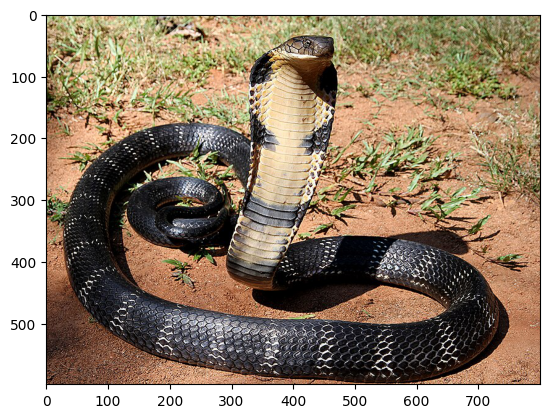

In [13]:
## Load image on which apply nearest neighbour search

image_pil = Image.open('images/Indian_cobra.png')
image = preprocess(image_pil)[np.newaxis, :, :, :]
_ = plt.imshow(image_pil)

In [31]:
# Load the heads components you want to analyze
file = "output_dir/imagenet_with_nr_elem_head_30_and_5_components_for_topic_The zoom-up main object in the image._model_ViT-B-32.txt"
file_content =  open(file, "r")
nr_components = re.search(r"(\d+)_components", file).group(1)
topic = re.search(r"_(.+)_model", file).group(1)
# Get the components of the topic
components = []
for line in file_content.readlines():
    layer_match = re.match(r"Layer: (\d+), Head: (\d+), Rank: \d+, Similarity: (\d.)+, Text: (.+)", line)
    if layer_match:
        layer = int(layer_match.group(1))
        head = int(layer_match.group(2))
        contribution = float(layer_match.group(3))
        text = str(layer_match.group(4))
        # Evaluate clip embedding for the given text
        texts = tokenizer(text).to(device)  # tokenize
        topic_embedding = model.encode_text(texts)
        topic_embedding = F.normalize(topic_embedding, dim=-1)
        component = {"layer":layer, "head":head, "text":text, "embedding":topic_embedding, "contribution":contribution}
        components.append(component)

In [32]:
## Run the image:
prs.reinit() # Reinitialize the residual stream hook
with torch.no_grad():
    representation = model.encode_image(image.to(device), 
                                        attn_method='head_no_spatial', 
                                        normalize=False)
    attentions, mlps = prs.finalize(representation)  # attentions: [1, 12, 12, 512], [b, l, h, d] & mlps: [1, 12, 1024], [b, l + 1 (class), d]

In [34]:
# Get the needed components contributions from the attentions of an image
def get_contributions(attention, components):
    # Retrieve all the components of the topic
    query_embedding = None
    for component in components:
        component_embedding = component["embedding"]
        # project on the component embedding (already normalized)
        component_embedding_proj = attention[:, component["layer"], component["head"]] @ component_embedding.T @ component_embedding
        # weight with topic contribution
        component_embedding_proj = component["contribution"] * component_embedding_proj 
        if query_embedding is None:
            # Project on the topic embedding
            query_embedding = component_embedding_proj
            continue
        # Project on the topic embedding
        query_embedding += component_embedding_proj
    query_embedding = query_embedding / query_embedding.norm(dim=-1).unsqueeze(1)
    return query_embedding

In [35]:
topic_embedding = get_contributions(attentions, components)
print(topic_embedding.shape)

torch.Size([1, 512])


In [36]:
## Create the pool for the nn search from same dataset
ds_vis = ImageNet(root=imagenet_path, split="val", transform=visualization_preprocess) # For showing images
ds = ImageNet(root=imagenet_path, split="val", transform=preprocess) # For running the model

In [37]:
# Take only a subset (here 5000 samples, 1 per class)
init_samples_per_class = 50
step = 25
index = list(range(0, len(ds), step))
ds = torch.utils.data.Subset(ds, index)
ds_vis = torch.utils.data.Subset(ds_vis, index)
dataloader = DataLoader(
    ds, batch_size=batch_size, shuffle=False, num_workers=8
)

In [38]:
# Define the number of top and worst images to keep for each search head
nr_top_imgs = 10
nr_worst_imgs = 5

# Initialize dictionaries to store the top and worst scores for each search head
top_db = [(-float("inf"), None) for _ in range(nr_top_imgs)]
worst_db =[(-float("inf"), None) for _ in range(nr_worst_imgs)]
print(topic_embedding.shape)

# Go over the dataset and calculate scores for each search head
for index, (images, labels) in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
    images = images.to(device)
    with torch.no_grad():
        prs.reinit()
        current_representation = model.encode_image(images, attn_method='head_no_spatial', normalize=False)
        current_attentions, _ = prs.finalize(current_representation) 
        contributions = get_contributions(current_attentions, components)
        scores = contributions @ topic_embedding.T # Cosine similarity

        # Update top and worst scores for the current search head
        for i in range(min(batch_size, images.shape[0])):
            heapq.heappushpop(top_db, (scores[i].detach().cpu().numpy()[0], batch_size * index + i))
            heapq.heappushpop(worst_db, (-scores[i].detach().cpu().numpy()[0], batch_size * index + i))

# Sort the databases based on score
top_db = sorted(top_db, key=lambda x: -x[0])
worst_db = sorted(worst_db, key=lambda x: x[0])

torch.Size([1, 512])


100%|██████████| 125/125 [00:53<00:00,  2.32it/s]


[0.99922854, 0.9985379, 0.9985187, 0.9984349, 0.9983389, 0.9980626, 0.99798715, 0.9979467, 0.99764323, 0.99750125, 0.93367755, 0.9347114, 0.9413476, 0.943398, 0.9576117]
Displaying images for search head dir/imagenet_with_nr_elem_head_30_and_5_components_for_topic_The zoom-up main object in the image.


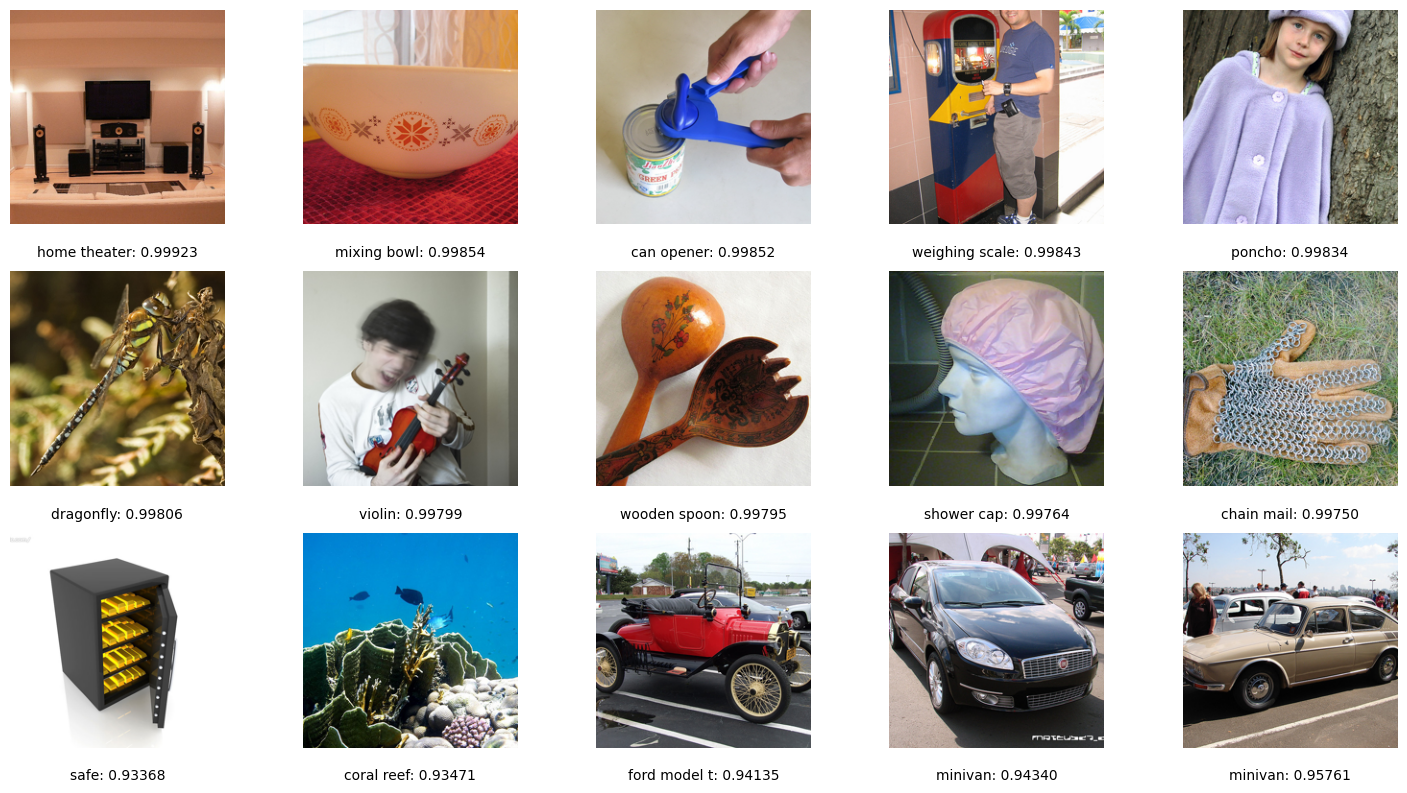

In [39]:
# Example usage: Display top and worst images for each search head
images, labels, scores = [], [], []

# Add top images for the current head
for score, image_index in top_db:
    images.append(ds_vis[image_index][0])
    labels.append(imagenet_classes[ds_vis[image_index][1]])
    scores.append(score)

# Add worst images for the current head
for score, image_index in worst_db:
    images.append(ds_vis[image_index][0])
    labels.append(imagenet_classes[ds_vis[image_index][1]])
    scores.append(score)

print(scores)
print(f"Displaying images for search head {topic}")
image_grid(images, 3, 5, labels=labels, scores=scores)
